In [1]:
import torch
import pickle
import numpy as np
from evaluation import *
from functions import *
from Models.AutoEncoder import *
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Loading dataset
x = pickle.load(open("./Xs.pkl", "rb"))
y = pickle.load(open("./Ys.pkl", "rb"))
x = np.nan_to_num(x)
y = np.nan_to_num(y)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.FloatTensor(x)
y = torch.FloatTensor(y)

In [4]:
# Computing Mean Square of features to equally prioritize each feature in loss function
features_mse = torch.mean(y.view(-1, y.shape[-1]) ** 2, dim=0).view(1, -1, 1, 1).to(device)
print(features_mse)

tensor([[[[0.0134]],

         [[0.0003]],

         [[0.0002]]]], device='cuda:0')


In [5]:
# Shifting dimensions
x, y = x.permute(0, 3, 1, 2), y.permute(0, 3, 1, 2)
# Removing channel 1 in input channels
x = torch.cat((x[:, 0:1, :, :], x[:, 2:, :, :]), dim=1)

In [6]:
print(x.shape)
print(y.shape)

torch.Size([961, 3, 172, 79])
torch.Size([961, 3, 172, 79])


In [7]:
# Shuffling the dataset
x, y = shuffle_tensors(x, y)

In [8]:
# Spliting dataset into 70% train and 30% test
train_data, test_data = split_tensors(x, y, ratio=0.7)
train_dataset, test_dataset = TensorDataset(*train_data), TensorDataset(*test_data)

In [9]:
# Creating model
model = AutoEncoder(3, 3, kernel_size=7, batch_norm=False, weight_norm=False)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      (1): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(16, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    )
  )
)

In [10]:
# Initializing weights
# initialize(model)

In [11]:
# Initializing optimizer
lr = 1e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [12]:
# Defining loss function
def loss_func(model, batch):
    x, y = batch
    output = model(x)
    loss = ((output - y) ** 2) / features_mse
    return torch.sum(loss) / len(x), output

In [13]:
# Selecting sample from test dataset for visualization
sample_x, sample_y = test_data[0][0:1].to(device), test_data[1][0:1].to(device)

In [14]:
# Computing output and error for test sample
def compute_error(model, sample_x, sample_y):
    with torch.no_grad():
        out_y = model(sample_x)
        error = torch.abs(sample_y - out_y)
        return out_y, error

In [15]:
# Visualize sample
def visualize(sample_y, out_y, error):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(15, 10)
    plt.subplot(3, 3, 1)
    plt.title('CFD', fontsize=18) 
    plt.imshow(np.transpose(sample_y[0,0,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Ux', fontsize=18)
    plt.subplot(3, 3, 2)
    plt.title('CNN', fontsize=18) 
    plt.imshow(np.transpose(out_y[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 3)
    plt.title('Error', fontsize=18)
    plt.imshow(np.transpose(error[0,0,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 4)
    plt.imshow(np.transpose(sample_y[0,1,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('Uy', fontsize=18)
    plt.subplot(3, 3, 5)
    plt.imshow(np.transpose(out_y[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 6)
    plt.imshow(np.transpose(error[0,1,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')

    plt.subplot(3, 3, 7)
    plt.imshow(np.transpose(sample_y[0,2,:,:]) , cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.ylabel('p', fontsize=18)
    plt.subplot(3, 3, 8)
    plt.imshow(np.transpose(out_y[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.subplot(3, 3, 9)
    plt.imshow(np.transpose(error[0,2,:,:]), cmap='jet')
    plt.colorbar(orientation='horizontal')
    plt.tight_layout()
    plt.show()

In [16]:
# Visualize after N epochs
def after_epoch(scope):
    epoch = scope["epoch"]
    best_model = scope["best_model"]
    if epoch % 10 == 0:
        out_y, error = compute_error(best_model, sample_x, sample_y)
        visualize(sample_y.cpu().numpy(), out_y.cpu().numpy(), error.cpu().numpy())

Epoch #1
	Train Loss = 1117169.609375
	Validation Loss = 414506.26171875
Model saved!
Epoch #2
	Train Loss = 862864.744140625
	Validation Loss = 355023.35546875
Model saved!
Epoch #3
	Train Loss = 764242.1484375
	Validation Loss = 315104.080078125
Model saved!
Epoch #4
	Train Loss = 693217.4296875
	Validation Loss = 286410.830078125
Model saved!
Epoch #5
	Train Loss = 636904.576171875
	Validation Loss = 262533.59765625
Model saved!
Epoch #6
	Train Loss = 590352.75390625
	Validation Loss = 244217.326171875
Model saved!
Epoch #7
	Train Loss = 551682.15234375
	Validation Loss = 226349.482421875
Model saved!
Epoch #8
	Train Loss = 505860.9619140625
	Validation Loss = 199812.77734375
Model saved!
Epoch #9
	Train Loss = 455125.951171875
	Validation Loss = 178060.994140625
Model saved!
Epoch #10
	Train Loss = 411375.77734375
	Validation Loss = 158040.3818359375
Model saved!


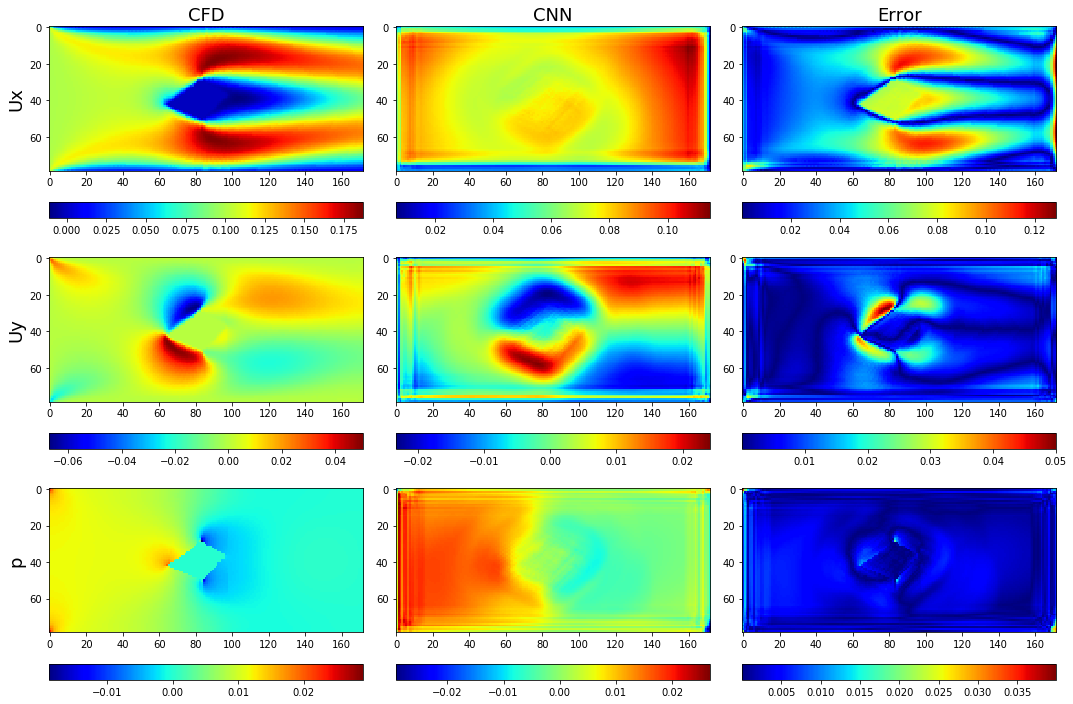

Epoch #11
	Train Loss = 377289.3662109375
	Validation Loss = 143667.8818359375
Model saved!
Epoch #12
	Train Loss = 350924.482421875
	Validation Loss = 134830.4892578125
Model saved!
Epoch #13
	Train Loss = 329963.7705078125
	Validation Loss = 122592.31005859375
Model saved!
Epoch #14
	Train Loss = 311956.32958984375
	Validation Loss = 114399.39697265625
Model saved!
Epoch #15
	Train Loss = 299645.5546875
	Validation Loss = 108707.33251953125
Model saved!
Epoch #16
	Train Loss = 288912.51220703125
	Validation Loss = 104037.03271484375
Model saved!
Epoch #17
	Train Loss = 280375.69482421875
	Validation Loss = 99869.33203125
Model saved!
Epoch #18
	Train Loss = 270922.14990234375
	Validation Loss = 95675.86474609375
Model saved!
Epoch #19
	Train Loss = 263663.083984375
	Validation Loss = 92733.85888671875
Model saved!
Epoch #20
	Train Loss = 260403.447265625
	Validation Loss = 90500.51879882812
Model saved!


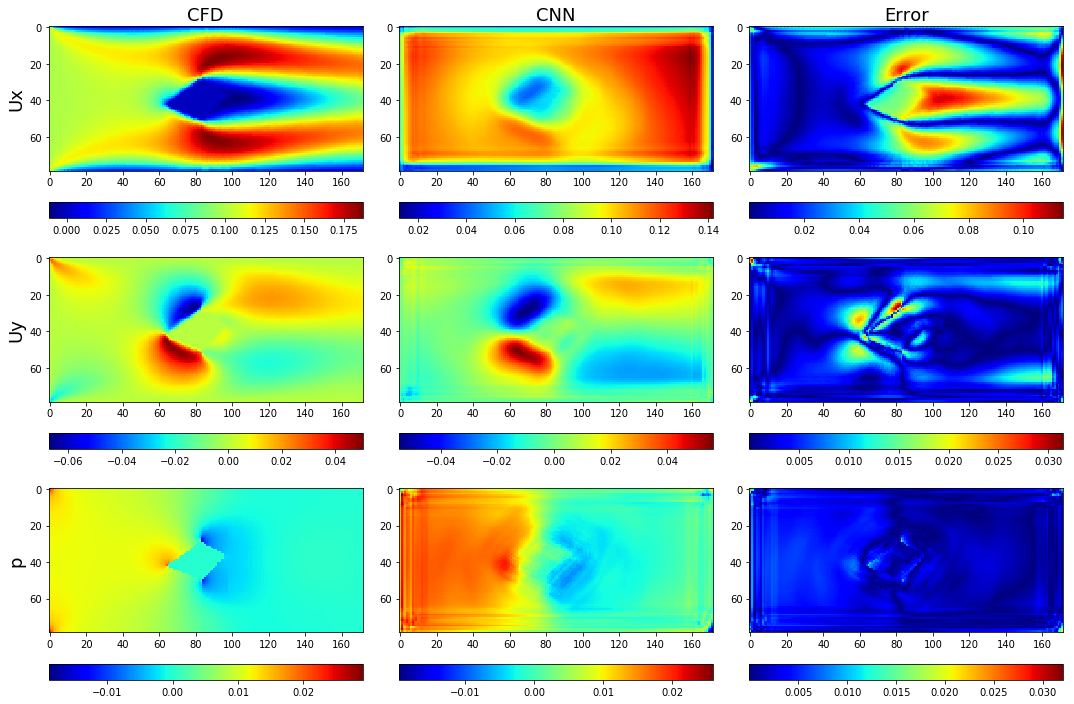

Epoch #21
	Train Loss = 255472.89404296875
	Validation Loss = 89659.22998046875
Model saved!
Epoch #22
	Train Loss = 254167.39013671875
	Validation Loss = 87286.19970703125
Model saved!
Epoch #23
	Train Loss = 250339.40576171875
	Validation Loss = 87790.75415039062
Epoch #24
	Train Loss = 246888.35302734375
	Validation Loss = 85612.78125
Model saved!
Epoch #25
	Train Loss = 244783.1474609375
	Validation Loss = 84164.34008789062
Model saved!
Epoch #26
	Train Loss = 244270.4951171875
	Validation Loss = 83717.00341796875
Model saved!
Epoch #27
	Train Loss = 240276.98974609375
	Validation Loss = 82453.62646484375
Model saved!
Epoch #28
	Train Loss = 238604.30029296875
	Validation Loss = 81136.99267578125
Model saved!
Epoch #29
	Train Loss = 236666.84716796875
	Validation Loss = 80849.673828125
Model saved!
Epoch #30
	Train Loss = 234376.94775390625
	Validation Loss = 82039.94287109375


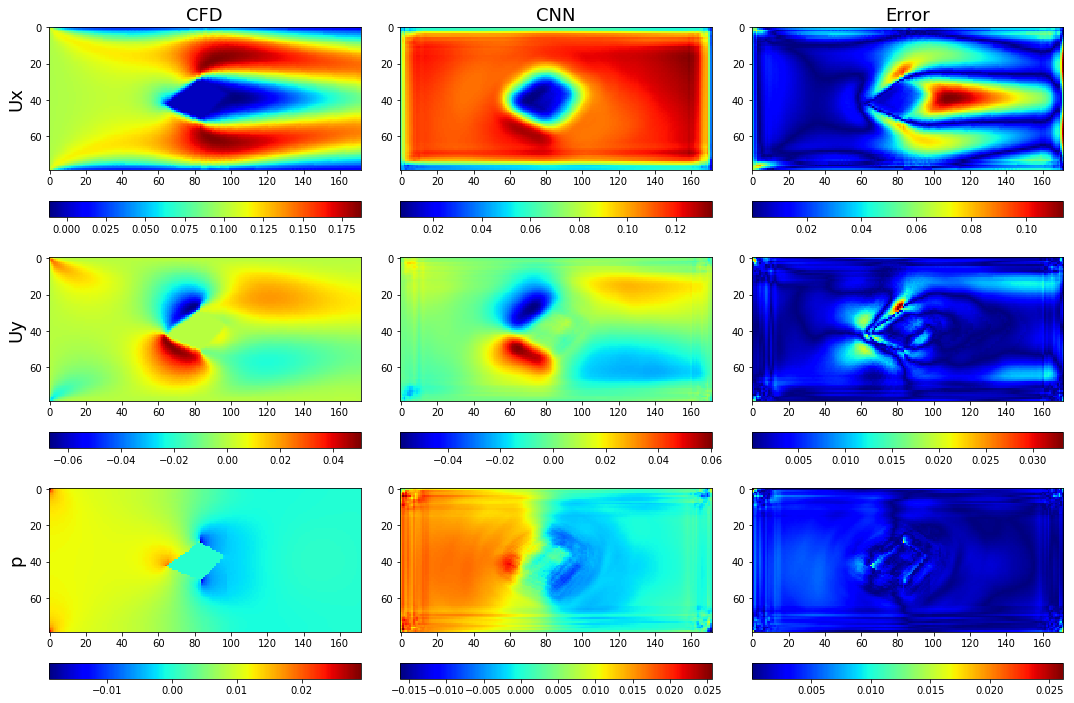

Epoch #31
	Train Loss = 235920.95458984375
	Validation Loss = 80561.02001953125
Model saved!
Epoch #32
	Train Loss = 232503.7021484375
	Validation Loss = 79109.97314453125
Model saved!
Epoch #33
	Train Loss = 230436.46313476562
	Validation Loss = 77572.2587890625
Model saved!
Epoch #34
	Train Loss = 229023.10791015625
	Validation Loss = 77567.27905273438
Model saved!
Epoch #35
	Train Loss = 227884.81713867188
	Validation Loss = 77608.41381835938
Epoch #36
	Train Loss = 226956.27612304688
	Validation Loss = 76030.78881835938
Model saved!
Epoch #37
	Train Loss = 226348.77758789062
	Validation Loss = 76534.451171875
Epoch #38
	Train Loss = 224948.27001953125
	Validation Loss = 75259.4951171875
Model saved!
Epoch #39
	Train Loss = 223487.57568359375
	Validation Loss = 75172.6748046875
Model saved!
Epoch #40
	Train Loss = 224558.39721679688
	Validation Loss = 74186.23706054688
Model saved!


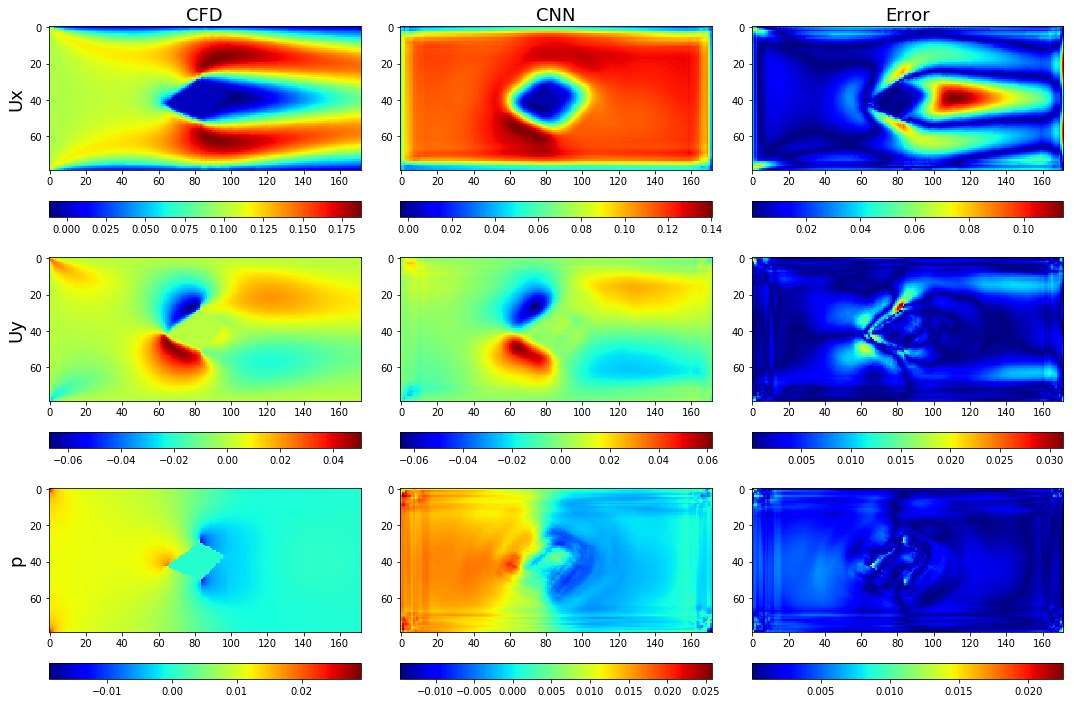

Epoch #41
	Train Loss = 220887.52026367188
	Validation Loss = 74436.89672851562
Epoch #42
	Train Loss = 221759.86059570312
	Validation Loss = 73400.18115234375
Model saved!
Epoch #43
	Train Loss = 220219.82958984375
	Validation Loss = 73109.53833007812
Model saved!
Epoch #44
	Train Loss = 219048.89965820312
	Validation Loss = 72558.17602539062
Model saved!
Epoch #45
	Train Loss = 217459.73510742188
	Validation Loss = 74956.28735351562
Epoch #46
	Train Loss = 219838.34912109375
	Validation Loss = 75786.88696289062
Epoch #47
	Train Loss = 218824.17211914062
	Validation Loss = 71914.45068359375
Model saved!
Epoch #48
	Train Loss = 215859.55981445312
	Validation Loss = 71212.30102539062
Model saved!
Epoch #49
	Train Loss = 214969.20703125
	Validation Loss = 71529.10180664062
Epoch #50
	Train Loss = 215882.1318359375
	Validation Loss = 72694.7548828125


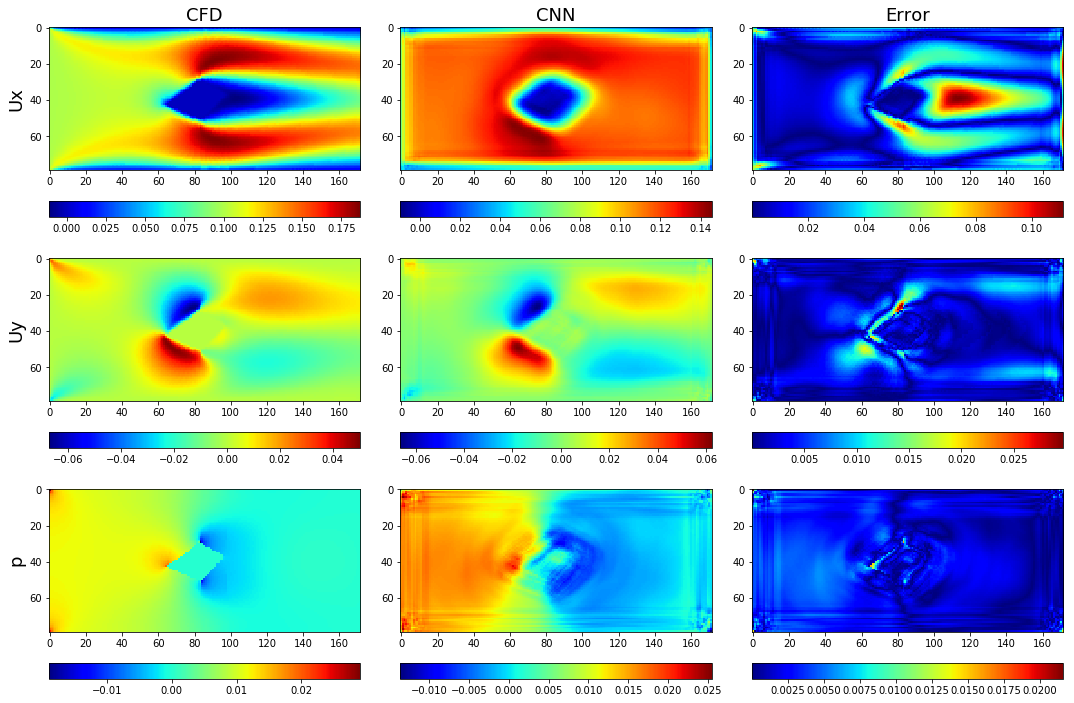

Epoch #51
	Train Loss = 215539.6875
	Validation Loss = 70292.5322265625
Model saved!
Epoch #52
	Train Loss = 213522.43188476562
	Validation Loss = 70134.62719726562
Model saved!
Epoch #53
	Train Loss = 213040.68920898438
	Validation Loss = 70933.20629882812
Epoch #54
	Train Loss = 211949.03076171875
	Validation Loss = 69370.49096679688
Model saved!
Epoch #55
	Train Loss = 211227.91943359375
	Validation Loss = 69368.39038085938
Model saved!
Epoch #56
	Train Loss = 212538.4306640625
	Validation Loss = 69941.7001953125
Epoch #57
	Train Loss = 213277.6787109375
	Validation Loss = 69296.78076171875
Model saved!
Epoch #58
	Train Loss = 208925.3466796875
	Validation Loss = 69309.95361328125
Epoch #59
	Train Loss = 211214.27563476562
	Validation Loss = 70396.55004882812
Epoch #60
	Train Loss = 211511.21875
	Validation Loss = 70326.84912109375


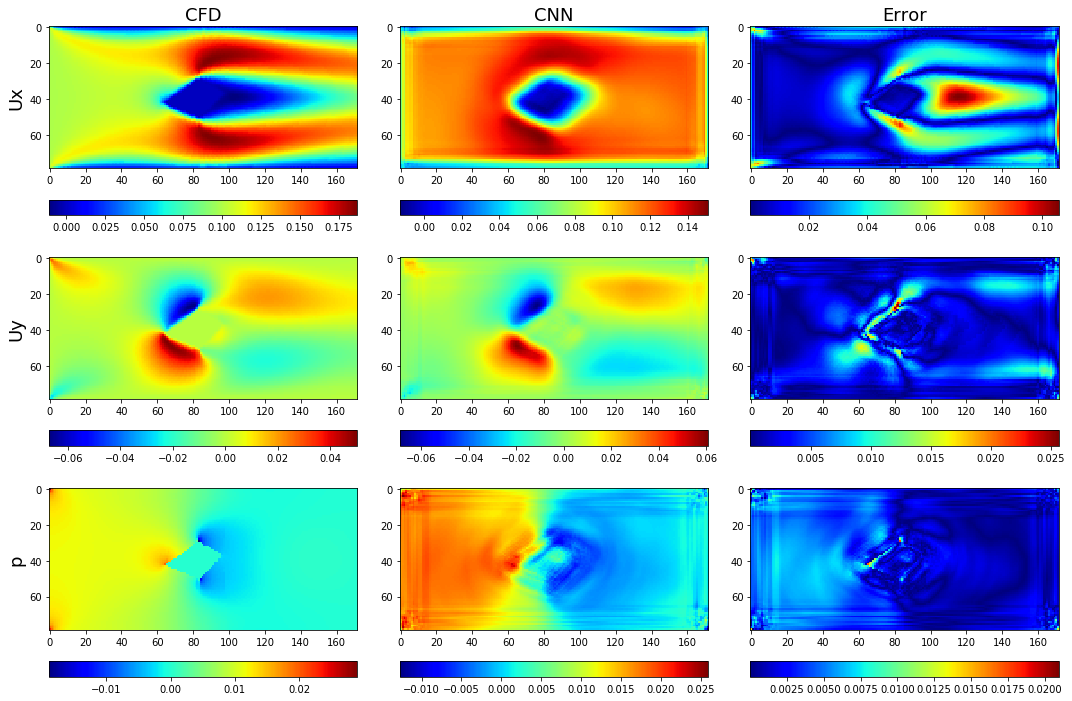

Epoch #61
	Train Loss = 211843.55932617188
	Validation Loss = 69141.44213867188
Model saved!
Epoch #62
	Train Loss = 208005.14868164062
	Validation Loss = 67635.05712890625
Model saved!
Epoch #63
	Train Loss = 206886.18774414062
	Validation Loss = 67091.9775390625
Model saved!
Epoch #64
	Train Loss = 206070.22314453125
	Validation Loss = 69998.91357421875
Epoch #65
	Train Loss = 212118.861328125
	Validation Loss = 66846.29406738281
Model saved!
Epoch #66
	Train Loss = 205606.63110351562
	Validation Loss = 65749.33642578125
Model saved!
Epoch #67
	Train Loss = 204564.25927734375
	Validation Loss = 66094.32104492188
Epoch #68
	Train Loss = 203136.85864257812
	Validation Loss = 65485.76220703125
Model saved!
Epoch #69
	Train Loss = 203733.0048828125
	Validation Loss = 66679.24951171875
Epoch #70
	Train Loss = 202732.45483398438
	Validation Loss = 64568.94372558594
Model saved!


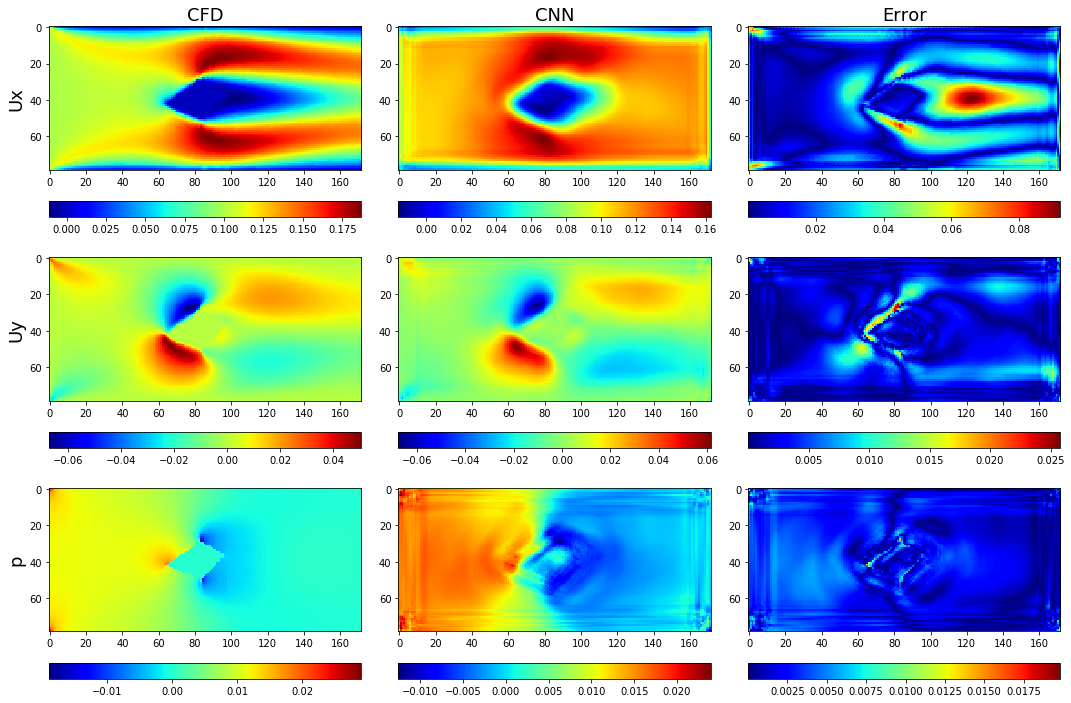

Epoch #71
	Train Loss = 200896.140625
	Validation Loss = 64259.44958496094
Model saved!
Epoch #72
	Train Loss = 201347.10009765625
	Validation Loss = 66378.63720703125
Epoch #73
	Train Loss = 200788.83544921875
	Validation Loss = 63822.64025878906
Model saved!
Epoch #74
	Train Loss = 198583.08813476562
	Validation Loss = 63442.346923828125
Model saved!
Epoch #75
	Train Loss = 198194.37719726562
	Validation Loss = 62792.5966796875
Model saved!
Epoch #76
	Train Loss = 198056.62231445312
	Validation Loss = 62505.11950683594
Model saved!
Epoch #77
	Train Loss = 196772.521484375
	Validation Loss = 62692.38427734375
Epoch #78
	Train Loss = 196533.22021484375
	Validation Loss = 61698.28796386719
Model saved!
Epoch #79
	Train Loss = 196020.955078125
	Validation Loss = 61907.927001953125
Epoch #80
	Train Loss = 194431.396484375
	Validation Loss = 60910.09582519531
Model saved!


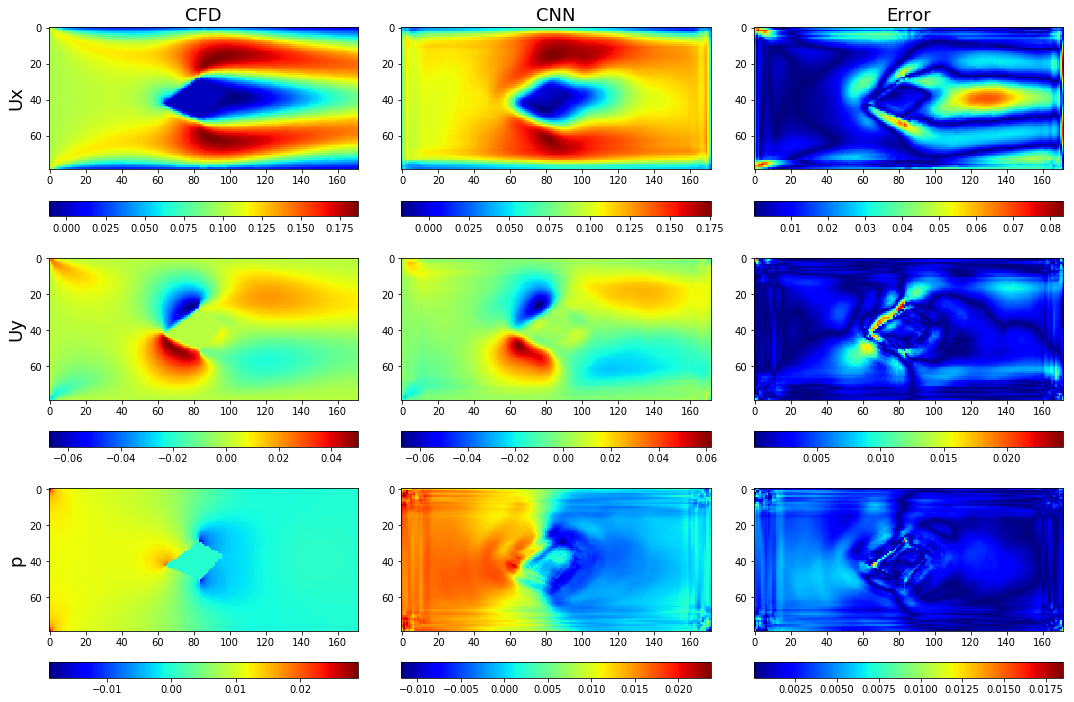

Epoch #81
	Train Loss = 193528.8359375
	Validation Loss = 62860.2607421875
Epoch #82
	Train Loss = 193282.12866210938
	Validation Loss = 59981.8369140625
Model saved!
Epoch #83
	Train Loss = 191390.05517578125
	Validation Loss = 60182.587890625
Epoch #84
	Train Loss = 194331.99243164062
	Validation Loss = 59619.973388671875
Model saved!
Epoch #85
	Train Loss = 191523.45874023438
	Validation Loss = 59760.238037109375
Epoch #86
	Train Loss = 190896.35229492188
	Validation Loss = 59322.916015625
Model saved!
Epoch #87
	Train Loss = 190831.16625976562
	Validation Loss = 61820.27795410156
Epoch #88
	Train Loss = 189717.4111328125
	Validation Loss = 59087.457275390625
Model saved!
Epoch #89
	Train Loss = 189546.80725097656
	Validation Loss = 59144.41357421875
Epoch #90
	Train Loss = 188240.60290527344
	Validation Loss = 58946.322021484375
Model saved!


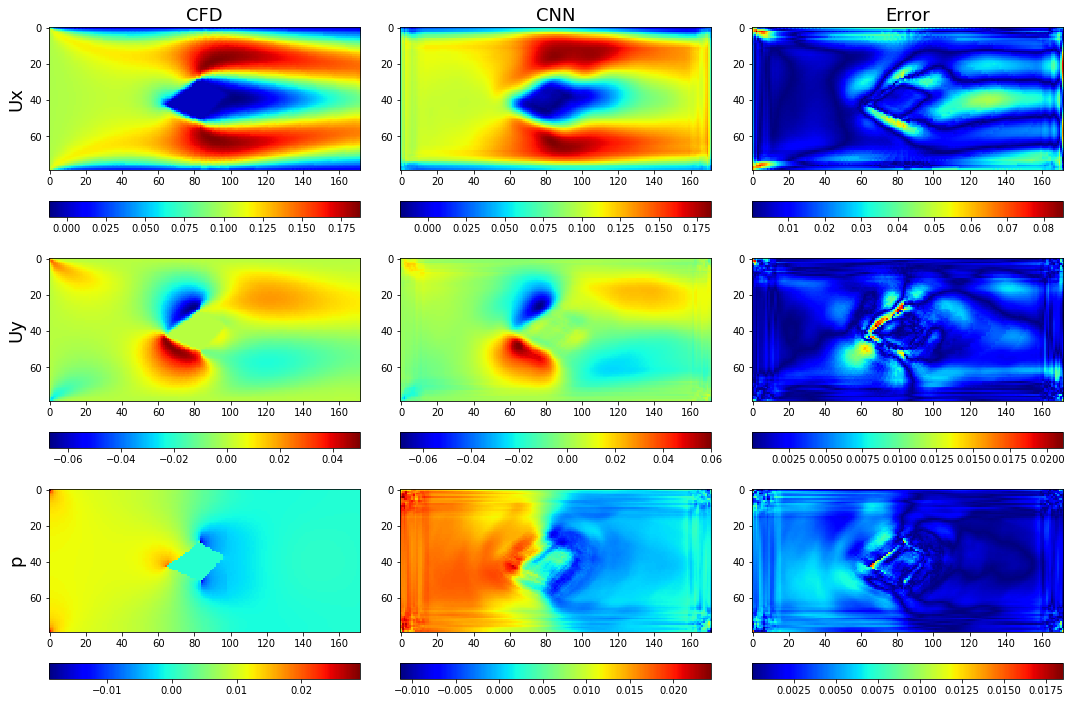

Epoch #91
	Train Loss = 187602.86987304688
	Validation Loss = 58306.46496582031
Model saved!
Epoch #92
	Train Loss = 185848.38500976562
	Validation Loss = 56753.85046386719
Model saved!
Epoch #93
	Train Loss = 184975.69653320312
	Validation Loss = 57014.75537109375
Epoch #94
	Train Loss = 184494.1611328125
	Validation Loss = 56589.70373535156
Model saved!
Epoch #95
	Train Loss = 184308.22387695312
	Validation Loss = 58127.86584472656
Epoch #96
	Train Loss = 184706.53576660156
	Validation Loss = 56639.353515625
Epoch #97
	Train Loss = 184187.5546875
	Validation Loss = 56813.86242675781
Epoch #98
	Train Loss = 184629.83862304688
	Validation Loss = 57049.70263671875
Epoch #99
	Train Loss = 184080.95275878906
	Validation Loss = 55288.028381347656
Model saved!
Epoch #100
	Train Loss = 182346.4229736328
	Validation Loss = 58330.85205078125


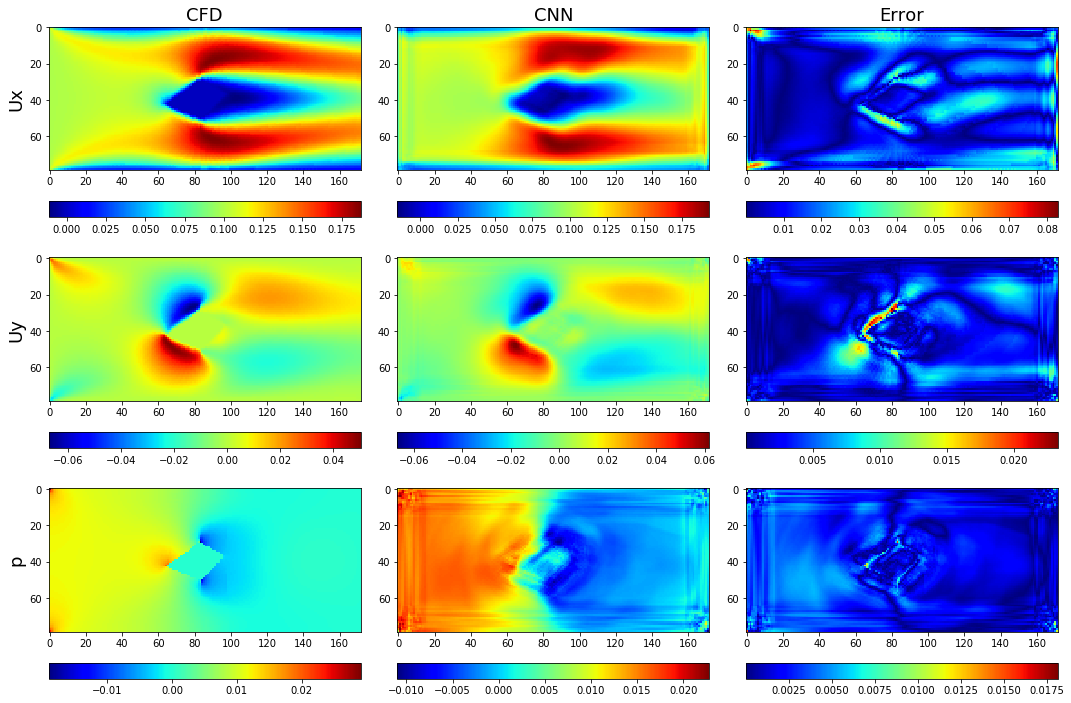

Epoch #101
	Train Loss = 183320.166015625
	Validation Loss = 55170.427490234375
Model saved!
Epoch #102
	Train Loss = 181139.83459472656
	Validation Loss = 54545.175537109375
Model saved!
Epoch #103
	Train Loss = 180164.3543701172
	Validation Loss = 54779.929260253906
Epoch #104
	Train Loss = 179965.14123535156
	Validation Loss = 54420.996643066406
Model saved!
Epoch #105
	Train Loss = 181496.9454345703
	Validation Loss = 54834.8173828125
Epoch #106
	Train Loss = 179681.73046875
	Validation Loss = 54974.29992675781
Epoch #107
	Train Loss = 180865.53552246094
	Validation Loss = 54486.53503417969
Epoch #108
	Train Loss = 180269.7705078125
	Validation Loss = 53812.34851074219
Model saved!
Epoch #109
	Train Loss = 181759.63891601562
	Validation Loss = 55071.880859375
Epoch #110
	Train Loss = 180383.9288330078
	Validation Loss = 53637.42468261719
Model saved!


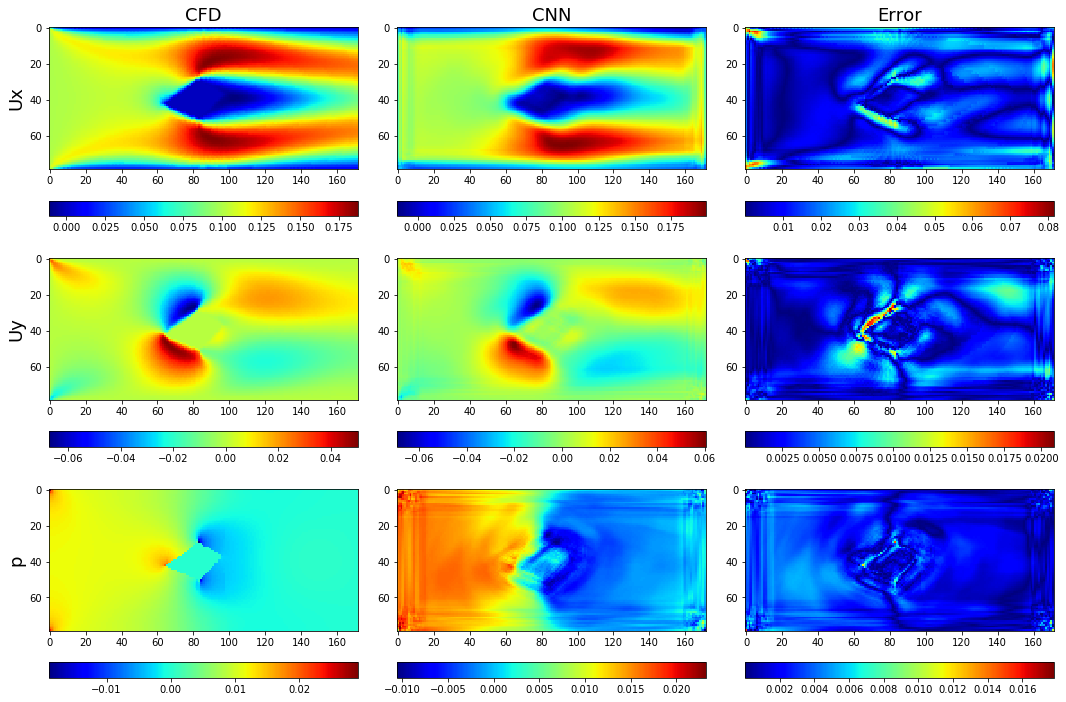

Epoch #111
	Train Loss = 179312.0860595703
	Validation Loss = 56019.13037109375
Epoch #112
	Train Loss = 180868.8555908203
	Validation Loss = 54189.00842285156
Epoch #113
	Train Loss = 180015.130859375
	Validation Loss = 54668.09600830078
Epoch #114
	Train Loss = 178650.38403320312
	Validation Loss = 53842.05242919922
Epoch #115
	Train Loss = 178481.3006591797
	Validation Loss = 53841.93176269531
Epoch #116
	Train Loss = 177792.67126464844
	Validation Loss = 53535.82470703125
Model saved!
Epoch #117
	Train Loss = 177221.97302246094
	Validation Loss = 52954.869140625
Model saved!
Epoch #118
	Train Loss = 178622.1651611328
	Validation Loss = 54682.53918457031
Epoch #119
	Train Loss = 177412.24487304688
	Validation Loss = 53361.43444824219
Epoch #120
	Train Loss = 176710.10546875
	Validation Loss = 53713.413818359375


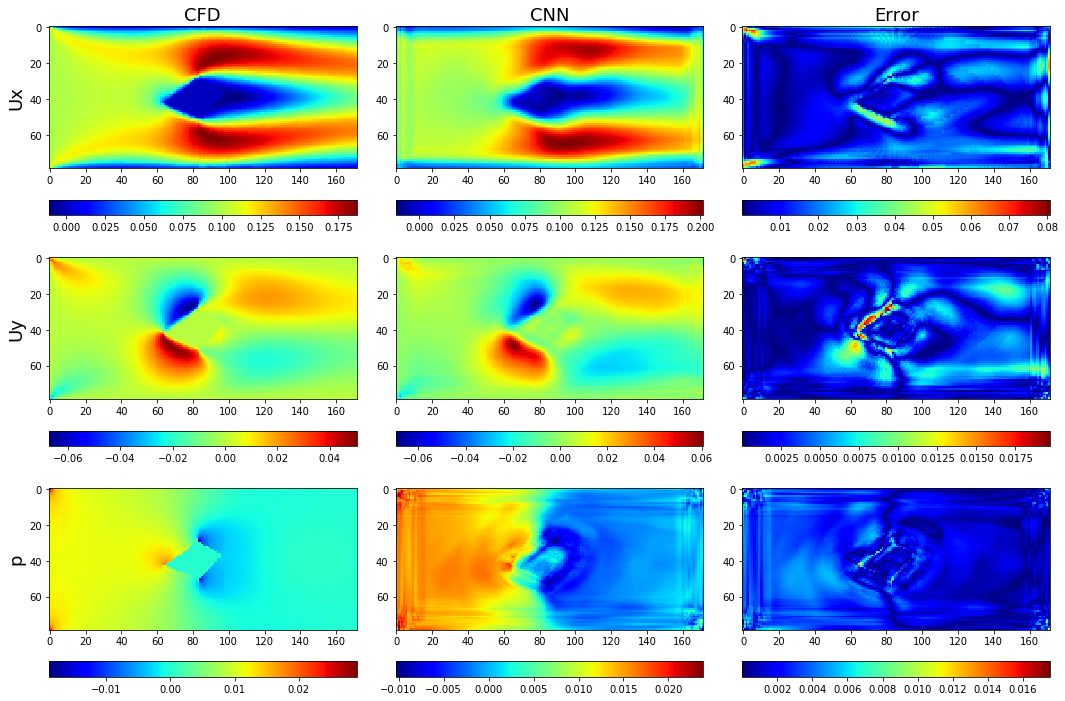

Epoch #121
	Train Loss = 177041.47229003906
	Validation Loss = 52987.073181152344
Epoch #122
	Train Loss = 180623.1934814453
	Validation Loss = 54879.68688964844
Epoch #123
	Train Loss = 177313.9248046875
	Validation Loss = 52637.21105957031
Model saved!
Epoch #124
	Train Loss = 175959.55151367188
	Validation Loss = 52177.89465332031
Model saved!
Epoch #125
	Train Loss = 176117.0625
	Validation Loss = 52525.91668701172
Epoch #126
	Train Loss = 175557.97436523438
	Validation Loss = 52437.24267578125
Epoch #127
	Train Loss = 174401.25524902344
	Validation Loss = 53081.134521484375
Epoch #128
	Train Loss = 176080.14770507812
	Validation Loss = 52888.807373046875
Epoch #129
	Train Loss = 176291.02856445312
	Validation Loss = 54406.59436035156
Epoch #130
	Train Loss = 176298.53161621094
	Validation Loss = 52747.40808105469


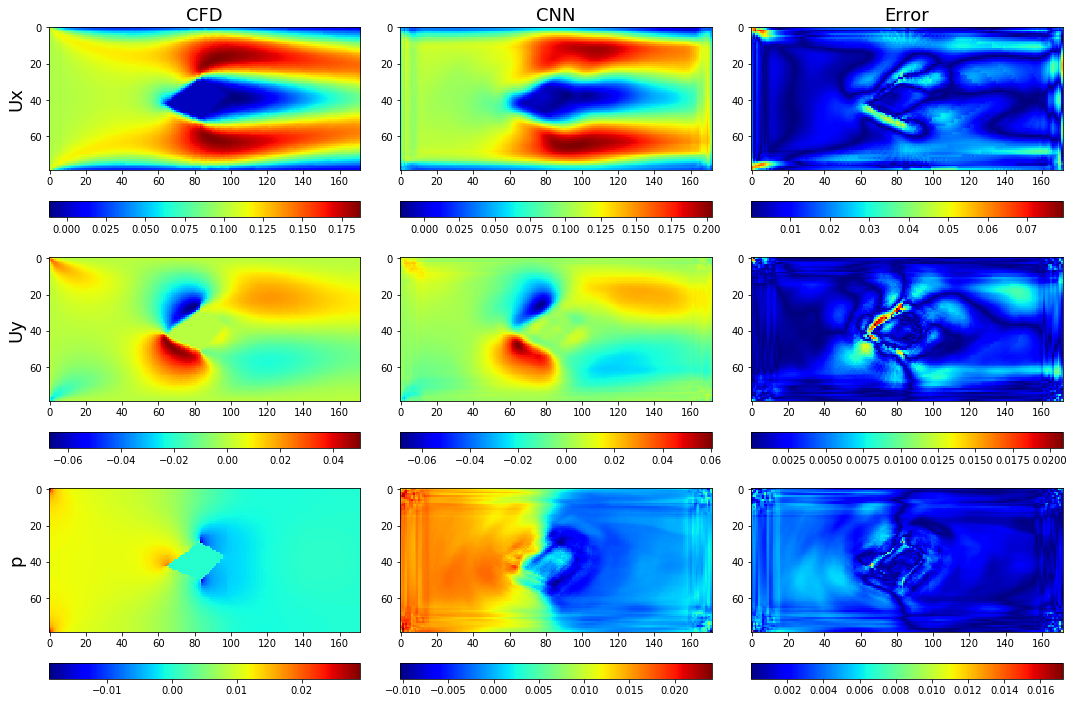

Epoch #131
	Train Loss = 176061.42651367188
	Validation Loss = 51755.05401611328
Model saved!
Epoch #132
	Train Loss = 176012.25854492188
	Validation Loss = 52798.497802734375
Epoch #133
	Train Loss = 175789.9503173828
	Validation Loss = 53096.70166015625
Epoch #134
	Train Loss = 176064.69921875
	Validation Loss = 51710.09442138672
Model saved!
Epoch #135
	Train Loss = 174299.3319091797
	Validation Loss = 51527.44104003906
Model saved!
Epoch #136
	Train Loss = 174605.93395996094
	Validation Loss = 52182.33166503906
Epoch #137
	Train Loss = 175486.28747558594
	Validation Loss = 52495.62390136719
Epoch #138
	Train Loss = 174422.58264160156
	Validation Loss = 51535.19665527344
Epoch #139
	Train Loss = 173760.11560058594
	Validation Loss = 51409.83447265625
Model saved!
Epoch #140
	Train Loss = 173691.45068359375
	Validation Loss = 51486.76110839844


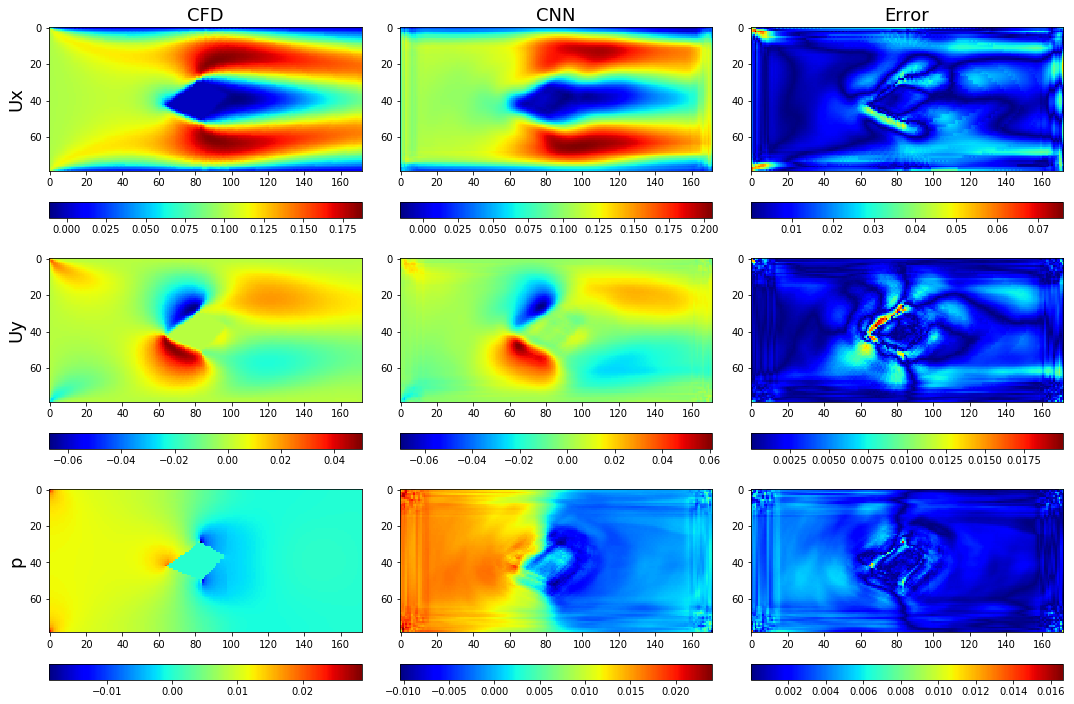

Epoch #141
	Train Loss = 173337.61865234375
	Validation Loss = 52317.88610839844
Epoch #142
	Train Loss = 174295.05639648438
	Validation Loss = 51782.322509765625
Epoch #143
	Train Loss = 175036.54528808594
	Validation Loss = 51868.258544921875
Epoch #144
	Train Loss = 173081.27978515625
	Validation Loss = 51301.71911621094
Model saved!
Epoch #145
	Train Loss = 173710.2225341797
	Validation Loss = 51698.674072265625
Epoch #146
	Train Loss = 173559.15856933594
	Validation Loss = 51481.93048095703
Epoch #147
	Train Loss = 172785.48852539062
	Validation Loss = 51371.78759765625
Epoch #148
	Train Loss = 175345.31811523438
	Validation Loss = 51409.52685546875
Epoch #149
	Train Loss = 174389.24584960938
	Validation Loss = 51878.965576171875
Epoch #150
	Train Loss = 173489.869140625
	Validation Loss = 51265.76904296875
Model saved!


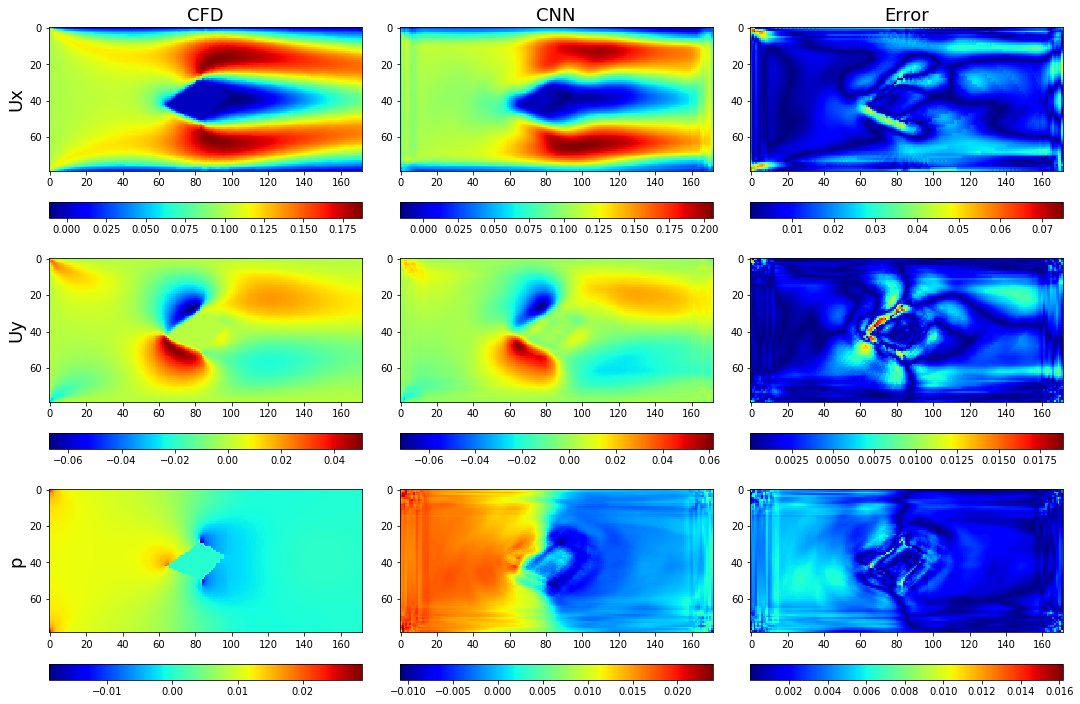

Epoch #151
	Train Loss = 173658.1280517578
	Validation Loss = 52446.342346191406
Epoch #152
	Train Loss = 174457.41040039062
	Validation Loss = 52016.231201171875
Epoch #153
	Train Loss = 173137.93005371094
	Validation Loss = 51708.819091796875
Epoch #154
	Train Loss = 172585.25024414062
	Validation Loss = 51445.2294921875
Epoch #155
	Train Loss = 172419.50622558594
	Validation Loss = 51006.29724121094
Model saved!
Epoch #156
	Train Loss = 172948.21142578125
	Validation Loss = 51181.80676269531
Epoch #157
	Train Loss = 172307.1240234375
	Validation Loss = 50856.28942871094
Model saved!
Epoch #158
	Train Loss = 173404.0108642578
	Validation Loss = 51624.18835449219
Epoch #159
	Train Loss = 172107.93713378906
	Validation Loss = 51799.41229248047
Epoch #160
	Train Loss = 172354.54345703125
	Validation Loss = 51193.192321777344


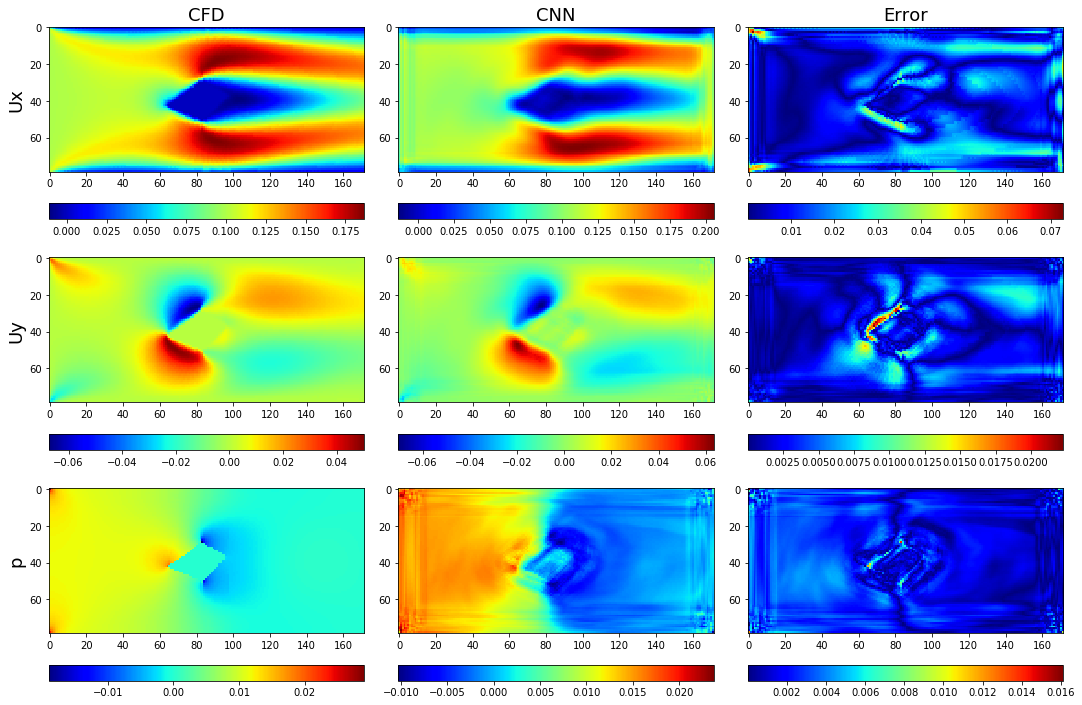

Epoch #161
	Train Loss = 172462.82739257812
	Validation Loss = 52067.588928222656
Epoch #162
	Train Loss = 172843.3494873047
	Validation Loss = 50793.368103027344
Model saved!
Epoch #163
	Train Loss = 171993.97973632812
	Validation Loss = 51132.91357421875
Epoch #164
	Train Loss = 171619.45959472656
	Validation Loss = 50647.06726074219
Model saved!
Epoch #165
	Train Loss = 172278.55993652344
	Validation Loss = 50630.37139892578
Model saved!
Epoch #166
	Train Loss = 171370.16186523438
	Validation Loss = 50324.65771484375
Model saved!
Epoch #167
	Train Loss = 172052.35607910156
	Validation Loss = 50986.82922363281
Epoch #168
	Train Loss = 172148.9249267578
	Validation Loss = 50800.33776855469
Epoch #169
	Train Loss = 172253.50134277344
	Validation Loss = 50675.22497558594
Epoch #170
	Train Loss = 173023.08374023438
	Validation Loss = 52262.598693847656


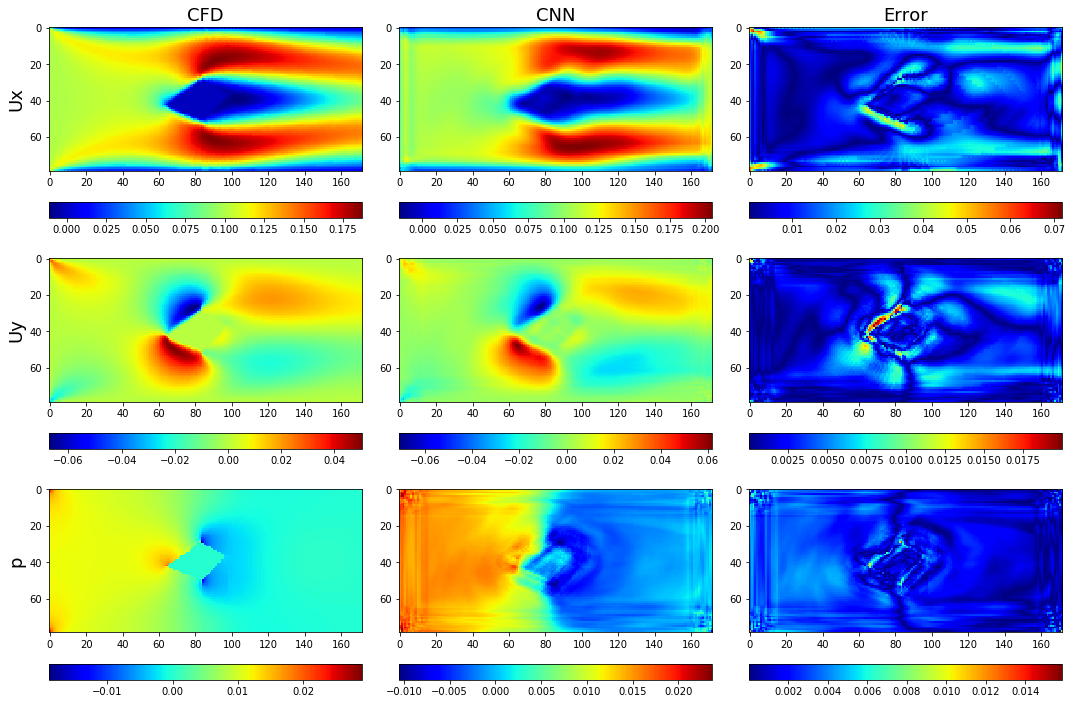

Epoch #171
	Train Loss = 172030.28662109375
	Validation Loss = 50896.60485839844
Epoch #172
	Train Loss = 171163.71057128906
	Validation Loss = 50327.55487060547
Epoch #173
	Train Loss = 171254.9725341797
	Validation Loss = 51991.419982910156
Epoch #174
	Train Loss = 171005.59521484375
	Validation Loss = 50986.47644042969
Epoch #175
	Train Loss = 171984.2567138672
	Validation Loss = 50350.59783935547
Epoch #176
	Train Loss = 171169.54956054688
	Validation Loss = 51760.96765136719
Early stopping...


(AutoEncoder(
   (encoder): Sequential(
     (0): Sequential(
       (0): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
       (1): ReLU()
     )
     (1): Sequential(
       (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
       (1): ReLU()
     )
     (2): Sequential(
       (0): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
       (1): ReLU()
     )
   )
   (decoder): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
       (1): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(32, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
       (1): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(16, 3, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
     )
   )
 ), {}, 171370.16186523438, {}, 50324.65771484375)

In [17]:
# Training model
train_model(model, loss_func, train_dataset, test_dataset, optimizer, epochs=10000, batch_size=32, device=device, after_epoch=after_epoch)